# Load data

In [99]:
import pandas as pd
df = pd.read_csv('train.csv')
df.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
0,1,A,B,A,A,B,D,A,E,C,...,0.881122,0.421650,0.741413,0.895799,0.802461,0.724417,0.701915,0.877618,0.719903,6.994023
1,2,B,A,A,A,B,B,A,E,A,...,0.440011,0.346230,0.278495,0.593413,0.546056,0.613252,0.741289,0.326679,0.808464,8.071256
2,3,A,A,A,C,B,D,A,B,C,...,0.914155,0.369602,0.832564,0.865620,0.825251,0.264104,0.695561,0.869133,0.828352,5.760456
3,4,A,A,A,C,B,D,A,E,G,...,0.934138,0.578930,0.407313,0.868099,0.794402,0.494269,0.698125,0.809799,0.614766,7.806457
4,6,A,B,A,A,B,B,A,E,C,...,0.382600,0.705940,0.325193,0.440967,0.462146,0.724447,0.683073,0.343457,0.297743,6.868974


In [100]:
cat_cols = [x for x in train.columns if x.startswith('cat')]
cat_cols

['cat0',
 'cat1',
 'cat2',
 'cat3',
 'cat4',
 'cat5',
 'cat6',
 'cat7',
 'cat8',
 'cat9']

In [101]:
for cat in cat_cols:
    df[cat] = df[cat].astype("category")

In [102]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, train_size = 0.5)

# Simple lightgbm model

In [104]:
from lightgbm.sklearn import LGBMRegressor
bt = LGBMRegressor(n_jobs=1)
x_train = train.drop(columns=['target','id'])
y_train = train['target']

In [105]:
bt.fit(x_train, y_train)

LGBMRegressor(n_jobs=1)

In [111]:
x_test = test.drop(columns=['target','id'])
y_test = test['target']

In [112]:
pred = bt.predict(x_test)

In [114]:
from sklearn.metrics import mean_squared_error
import math
math.sqrt(mean_squared_error(y_test, pred))

0.8462248296832514

In [108]:
from plotnine import ggplot, geom_point, aes
from plotnine.geoms import geom_histogram, geom_bar, geom_boxplot, geom_bin2d, geom_density_2d, geom_segment
from plotnine.labels import ggtitle

In [115]:
df_plot = pd.DataFrame({'pred':pred, 'y':y_test})

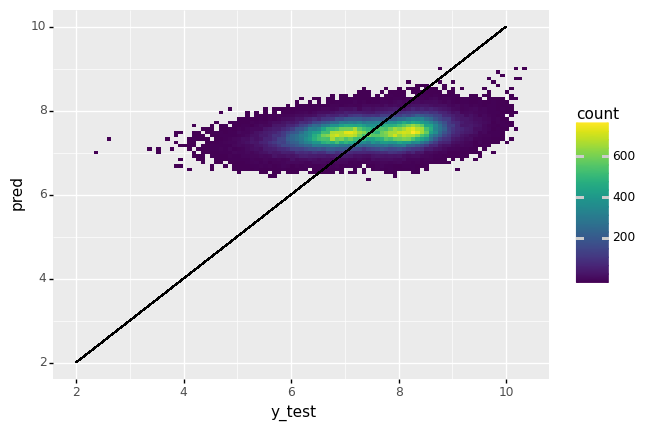

<ggplot: (8767507806010)>

In [116]:
ggplot(df_plot, aes(x='y_test', y='pred'))+geom_bin2d(bins = 100)+geom_segment(aes(x = 2, y = 2, xend = 10, yend = 10))

In [120]:
pd.melt(df_plot)

,variable,value
0,pred,7.463439
1,pred,7.456596
2,pred,7.847190
3,pred,7.293881
4,pred,7.321393
...,...,...
299995,y,8.482188
299996,y,8.498275
299997,y,7.652391
299998,y,7.600190


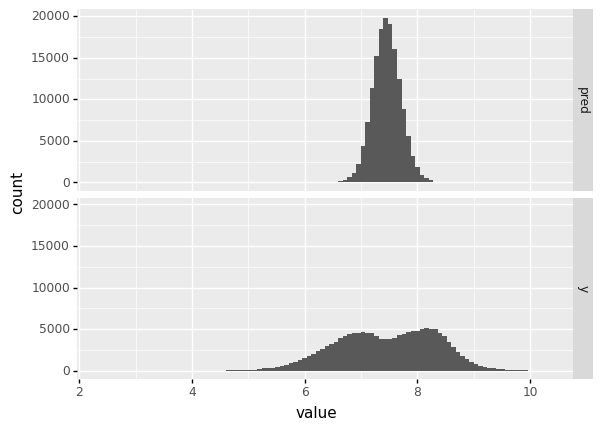

<ggplot: (8767507806028)>

In [123]:
df_plot_dist = pd.melt(df_plot)
from plotnine.facets import facet_grid
ggplot(df_plot_dist, aes(x='value', ))+geom_histogram(bins=100)+facet_grid('variable ~ .')

# Two part model

In [38]:
from lightgbm.sklearn import LGBMRegressor
from lightgbm.sklearn import LGBMClassifier

In [39]:
cb = LGBMClassifier()
cb.fit(x_train, y_train>7.5)

LGBMClassifier()

In [40]:
left = LGBMRegressor()
left.fit(x_train[y_train<=7.5], y_train[y_train<=7.5])

LGBMRegressor()

In [53]:
right = LGBMRegressor()
right.fit(x_train[y_train>7.5], y_train[y_train>7.5])

LGBMRegressor()

In [54]:
prob = cb.predict_proba(x_test)

In [55]:
left_pred = left.predict(x_test)
right_pred = right.predict(x_test)

In [56]:
prob

array([[0.60972472, 0.39027528],
       [0.48252458, 0.51747542],
       [0.40523177, 0.59476823],
       ...,
       [0.57704752, 0.42295248],
       [0.59298847, 0.40701153],
       [0.53310604, 0.46689396]])

In [73]:
pred = prob[:,0] * left_pred + prob[:,1] * right_pred

In [74]:
import math
math.sqrt(mean_squared_error(y_test[y_test>7.5], right_pred[y_test>7.5]))

0.42728851050693634

In [75]:
math.sqrt(mean_squared_error(y_test[y_test<=7.5], left_pred[y_test<=7.5]))

0.5086288381670008

In [76]:
math.sqrt(mean_squared_error(y_test, pred))

0.849212575019919

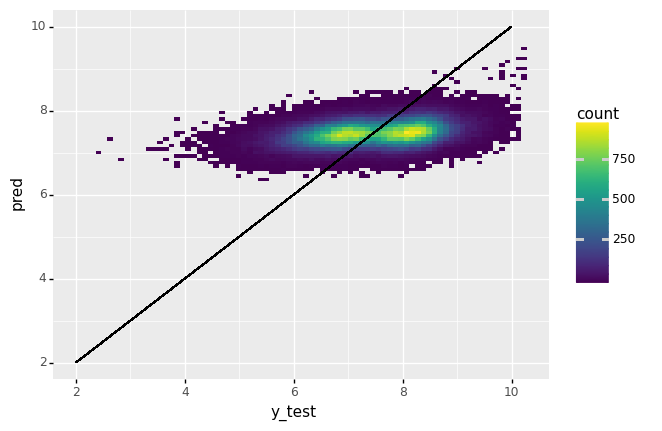

<ggplot: (8767409248362)>

In [79]:
df_plot = pd.DataFrame({'pred':pred, 'y':y_test})
ggplot(df_plot, aes(x='y_test', y='pred'))+geom_bin2d(bins = 100)+geom_segment(aes(x = 2, y = 2, xend = 10, yend = 10))

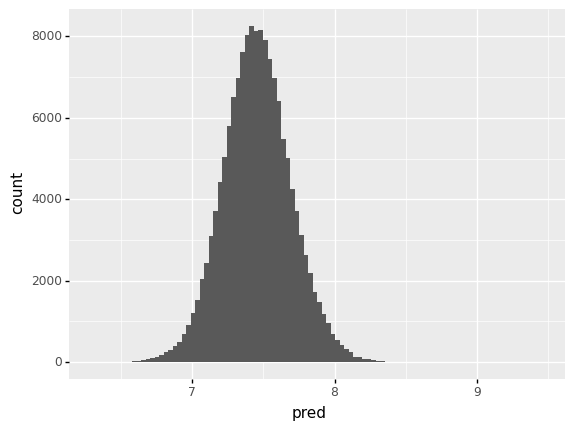

<ggplot: (8767409190867)>

In [80]:
ggplot(df_plot, aes(x='pred'))+geom_histogram(bins=100)

In [69]:
cl = cb.predict(x_test)

In [70]:
pred = (1-cl) * left_pred + cl * right_pred

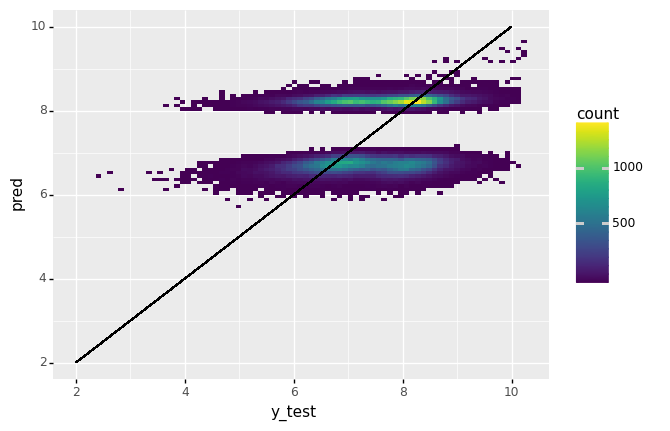

<ggplot: (8767603265404)>

In [71]:
df_plot = pd.DataFrame({'pred':pred, 'y':y_test})
ggplot(df_plot, aes(x='y_test', y='pred'))+geom_bin2d(bins = 100)+geom_segment(aes(x = 2, y = 2, xend = 10, yend = 10))

In [72]:
math.sqrt(mean_squared_error(y_test, pred))

1.0403281347408868

In [85]:
import numpy as np
np.max(prob)

0.9340809800752213

In [89]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test>7.5, prob[:,1])

0.6231597796500603

In [91]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test>7.5, cl)

0.5862066666666667

In [95]:
pred = 0.5*(left_pred + right_pred)

In [96]:
math.sqrt(mean_squared_error(y_test, pred))

0.8663146854897255

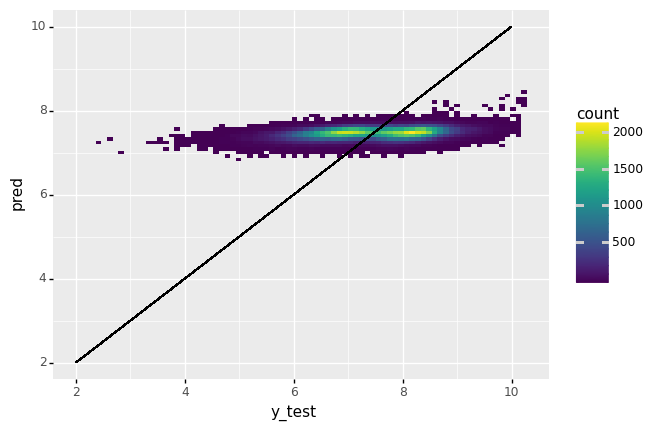

<ggplot: (8767434379825)>

In [97]:
df_plot = pd.DataFrame({'pred':pred, 'y':y_test})
ggplot(df_plot, aes(x='y_test', y='pred'))+geom_bin2d(bins = 100)+geom_segment(aes(x = 2, y = 2, xend = 10, yend = 10))